# Predicting weather in the next hour using raw data

This notebook demonstrates how we can use vector search for time series forecasting on climate data with Pinecone.
We use the [Jena Climate dataset](https://www.kaggle.com/stytch16/jena-climate-2009-2016) for this example. Jena Climate dataset is made up of quantities such as air temperature, atmospheric pressure, humidity, wind direction, etc. that were recorded every 10 minutes, over several years. 

In a tabular dataset like this, every column can be seen as a feature vector identified uniquely by the time stamp associated with them. We can use these vectors to perform similarity search with a given query vector at a certain time to predict the weather for that hour. Though a very simple embedding extraction process, we want to see how far we can get even with a basic similarity search method like this. We will see how to do with Pinecone in the steps below.



### Install Pinecone




In [1]:
!pip install -qU pinecone-client

In [2]:
import pinecone
import os

You can get your Pinecone API Key [here](https://www.pinecone.io/start/) if you don't have one.

In [3]:
# Load Pinecone API key
api_key = os.getenv('PINECONE_API_KEY') or 'YOUR_API_KEY'
# Set Pinecone environment. Default environment is us-west1-gcp
env = os.getenv('PINECONE_ENVIRONMENT') or 'us-west1-gcp'
pinecone.init(api_key=api_key, environment=env)

#List all present indexes associated with your key, should be empty on the first run
pinecone.list_indexes()

[]


### Import other dependencies

In [4]:
import matplotlib as mpl
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from typing import List
import itertools

mpl.rcParams['figure.figsize'] = (20, 16)
mpl.rcParams['axes.grid'] = False

### Load the dataset

In [5]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

Load the hourly data into a dataframe

In [6]:
original_data_for_insert = pd.read_csv(csv_path)
original_data_for_insert = original_data_for_insert[5::6]

original_data_for_insert['Date Time'] = pd.to_datetime(original_data_for_insert['Date Time'], format='%d.%m.%Y %H:%M:%S')

Split data into data that is going to be inserted into Pinecone, and data that is going to be used for querying. 

In [7]:
n = len(original_data_for_insert)
train_data = original_data_for_insert[:int(n*0.9)]
test_data = original_data_for_insert[int(n*0.9):]


Let's see what the data looks like.

In [8]:
train_data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Prepare data for upload. We will be querying data by the date and time.

In [9]:
items_to_upload = []
for row in train_data.values.tolist():
    key = str(row[0])
    values = row[1:]
    items_to_upload.append((key, values))

Prepare data that is going to be queried. 
Here we create two lists - one with dates that are going to be queried and the other one with vectors.



In [10]:
query_dates = []
query_data = []
for row in test_data.values.tolist():
    query_dates.append(str(row[0]))
    query_data.append(row[1:])

### Setting up an index

In [11]:
# Pick a name for the new service
index_name = 'time-series-weather'

In [12]:
# Check whether the index with the same name already exists
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

In [13]:
pinecone.create_index(name=index_name, dimension=14, metric='cosine', shards=1)

In [15]:
index = pinecone.Index(index_name=index_name)
index.describe_index_stats()

{'dimension': 0, 'namespaces': {}}

In [16]:
# Upload items
def chunks(iterable, batch_size=100):
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

for batch in chunks(items_to_upload, 500):
    index.upsert(vectors=batch)

In [17]:
# Check the index size to confirm the data was upserted properly
index.describe_index_stats()

{'dimension': 14, 'namespaces': {'': {'vector_count': 63057}}}

In [18]:
# Query items
all_query_results = []
for i in range(8):
    query_results = index.query(queries=query_data[i*1000:(i+1)*1000], top_k=1)
    all_query_results.extend(query_results.results)

Here we create a function for getting predictions from Pinecone. We do this by using vectors to find the most similar vector in the index and then reading the hour after that.

In [20]:
def get_predictions(feature: str) -> (List, List):

    true_values = []
    predicted_values = []

    for test_date, qr in zip(query_dates, all_query_results):
        similar_date = [res.id for res in qr.matches][0]
        hour_from_original = datetime.strptime(str(test_date), '%Y-%m-%d %H:%M:%S') + timedelta(hours=1) 
        hour_from_similar = datetime.strptime(similar_date, '%Y-%m-%d %H:%M:%S') + timedelta(hours=1)

        original_temperature = original_data_for_insert.loc[original_data_for_insert['Date Time'] == hour_from_original][feature].tolist()
        similar_temperature = original_data_for_insert.loc[original_data_for_insert['Date Time'] == hour_from_similar][feature].tolist()

        if original_temperature and similar_temperature:
            true_values.append(original_temperature[0])
            predicted_values.append(similar_temperature[0])
    return true_values, predicted_values


In [21]:
def plot_results(predicted_values: List, true_values: List):
    x_list = range(0, len(predicted_values))
    plt.plot(x_list[:200], predicted_values[:200], label='forecast')
    plt.plot(x_list[:200], true_values[:200], label='true')
    plt.legend()
    plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def print_results(true_values: List, predicted_values: List):
    print(f'MSE: {mean_squared_error(true_values, predicted_values)}')
    print(f'RMSE: {mean_squared_error(true_values, predicted_values, squared=False)}')
    print(f'MAE: {mean_absolute_error(true_values, predicted_values)}')

### Results

To evaluate our results we will plot the predicted and true values for all the 14 features. 

Analyzing predictions for p (mbar)


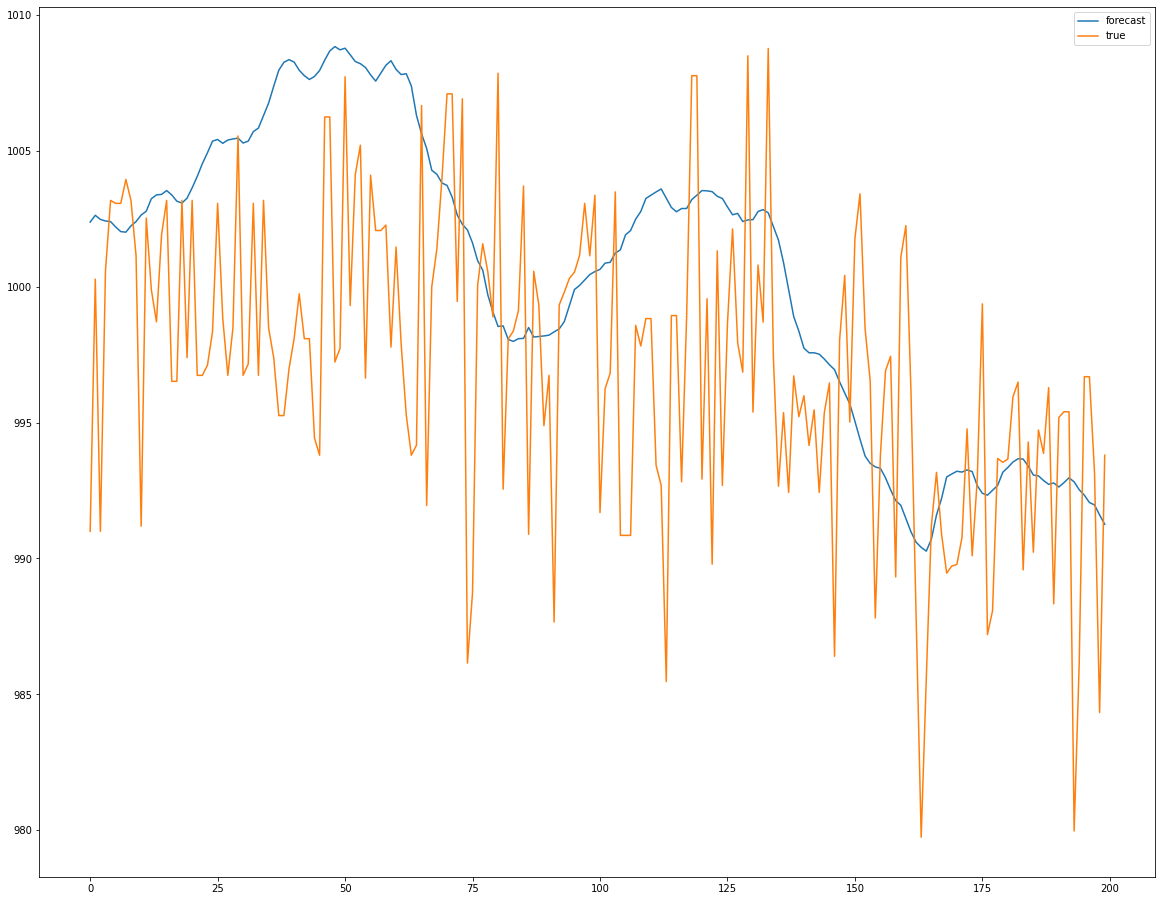

MSE: 27.59220627853881
RMSE: 5.2528284074904645
MAE: 4.094874429223744
Analyzing predictions for T (degC)


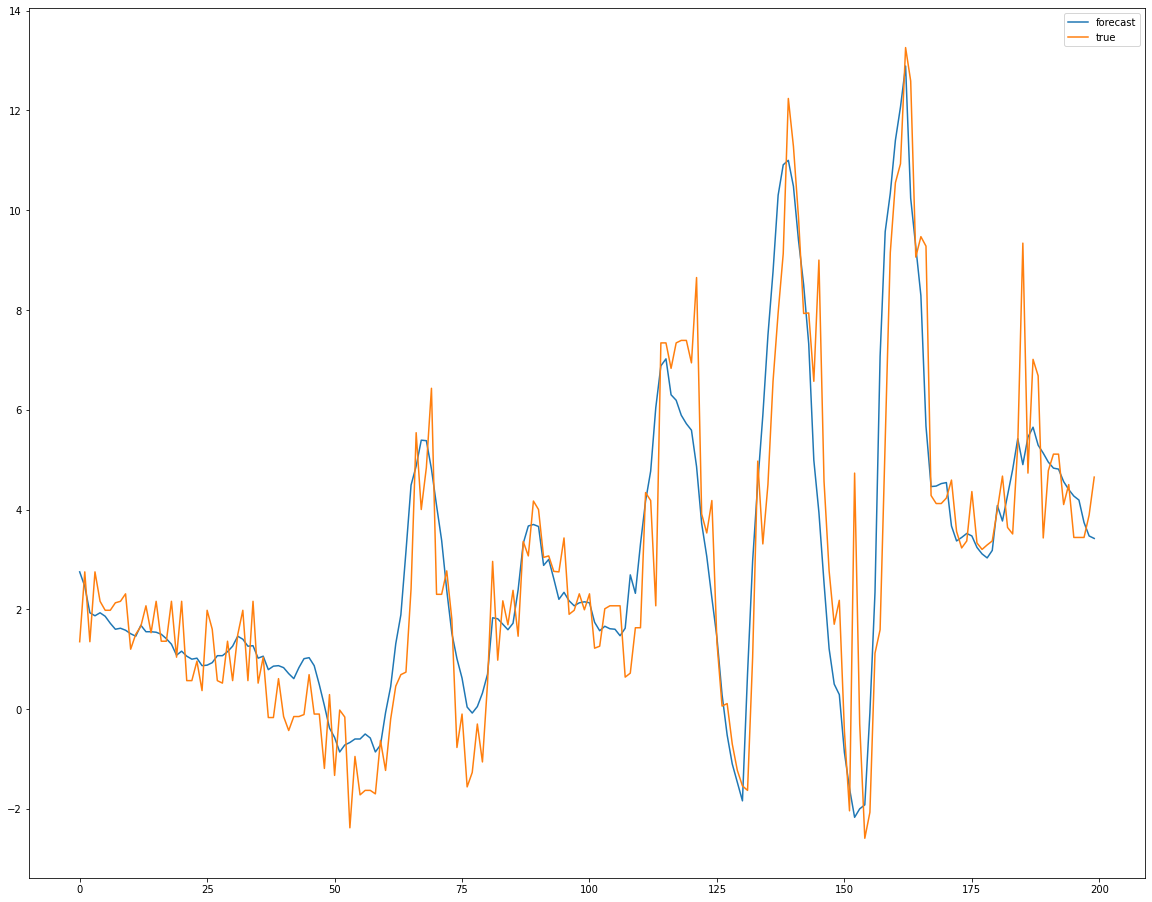

MSE: 2.180772046232877
RMSE: 1.476743730724081
MAE: 1.103782819634703
Analyzing predictions for Tpot (K)


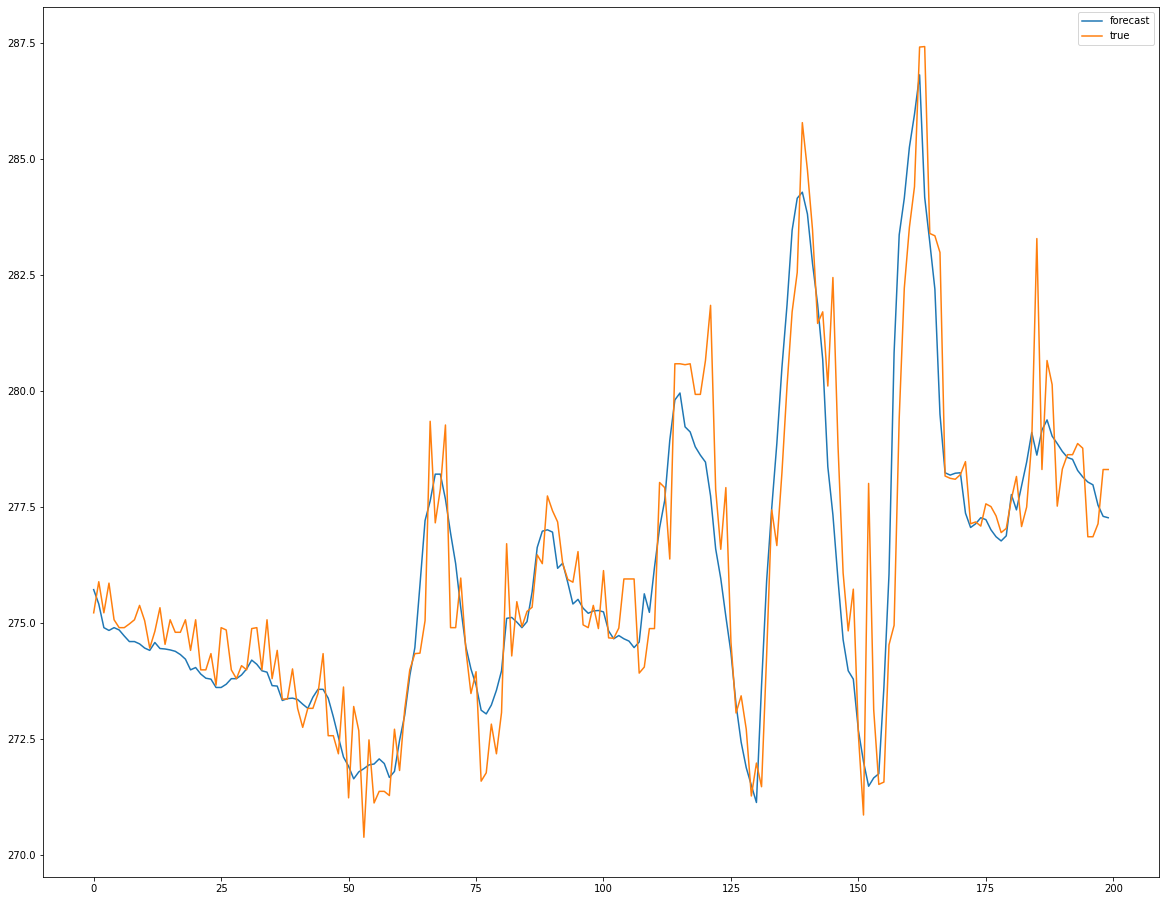

MSE: 2.173852325913242
RMSE: 1.4743989710771104
MAE: 1.0979352168949772
Analyzing predictions for Tdew (degC)


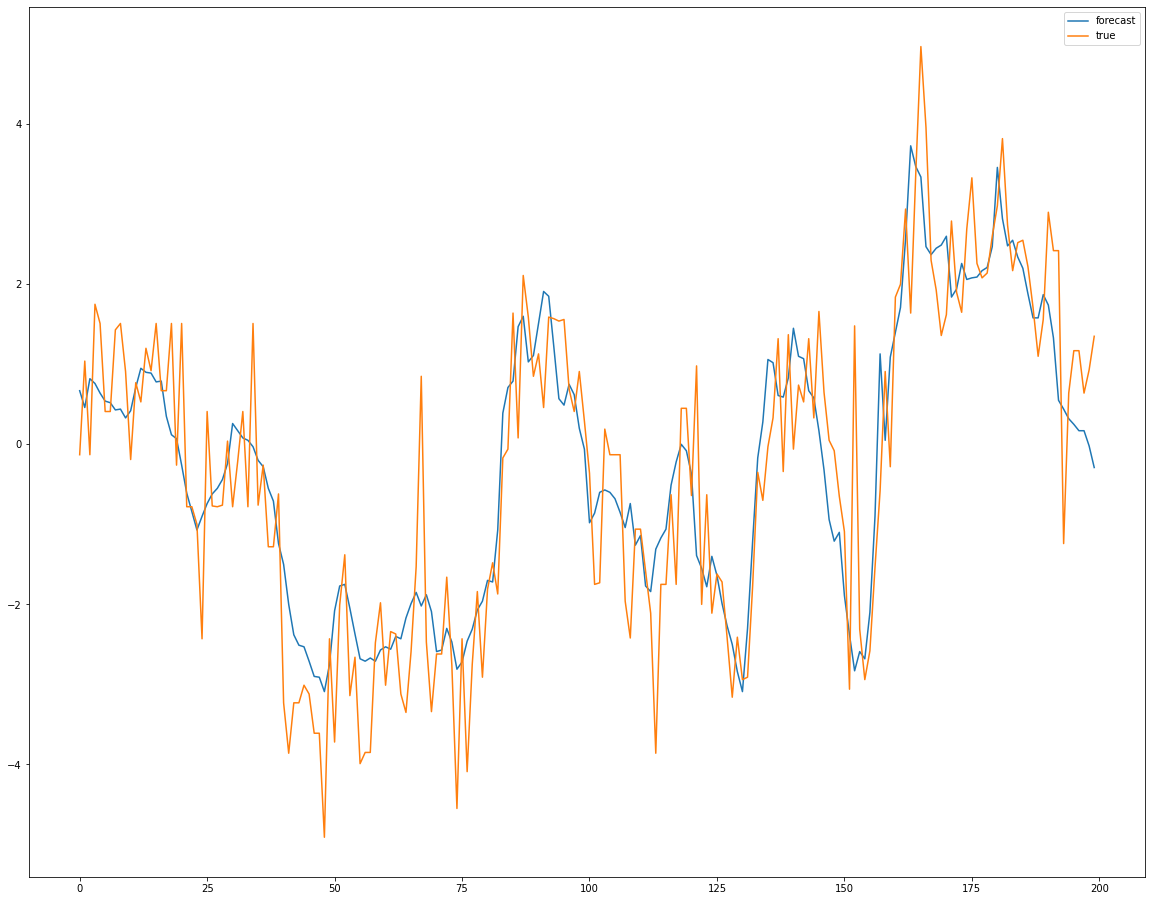

MSE: 1.0255985587899543
RMSE: 1.0127184005388439
MAE: 0.7660345319634703
Analyzing predictions for rh (%)


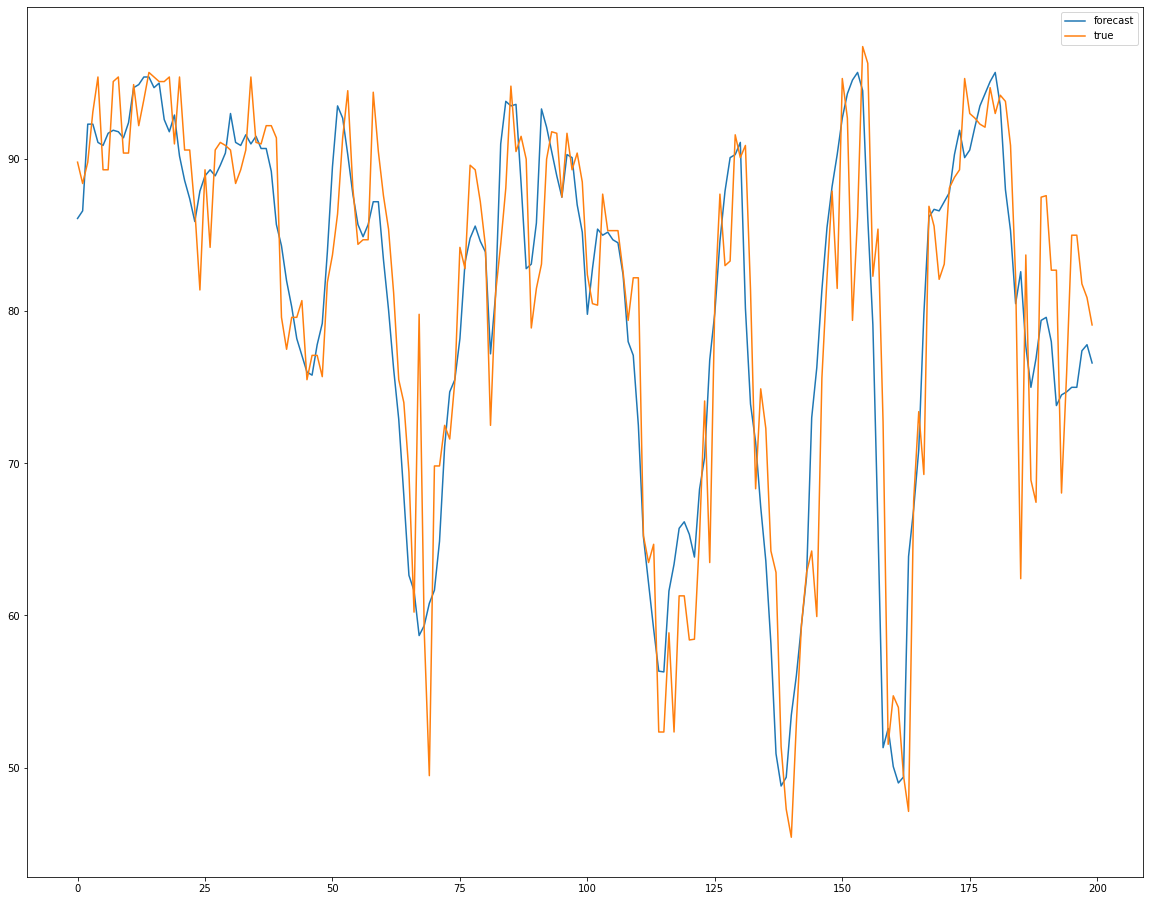

MSE: 41.595423202054796
RMSE: 6.4494513876805675
MAE: 4.677651255707762
Analyzing predictions for VPmax (mbar)


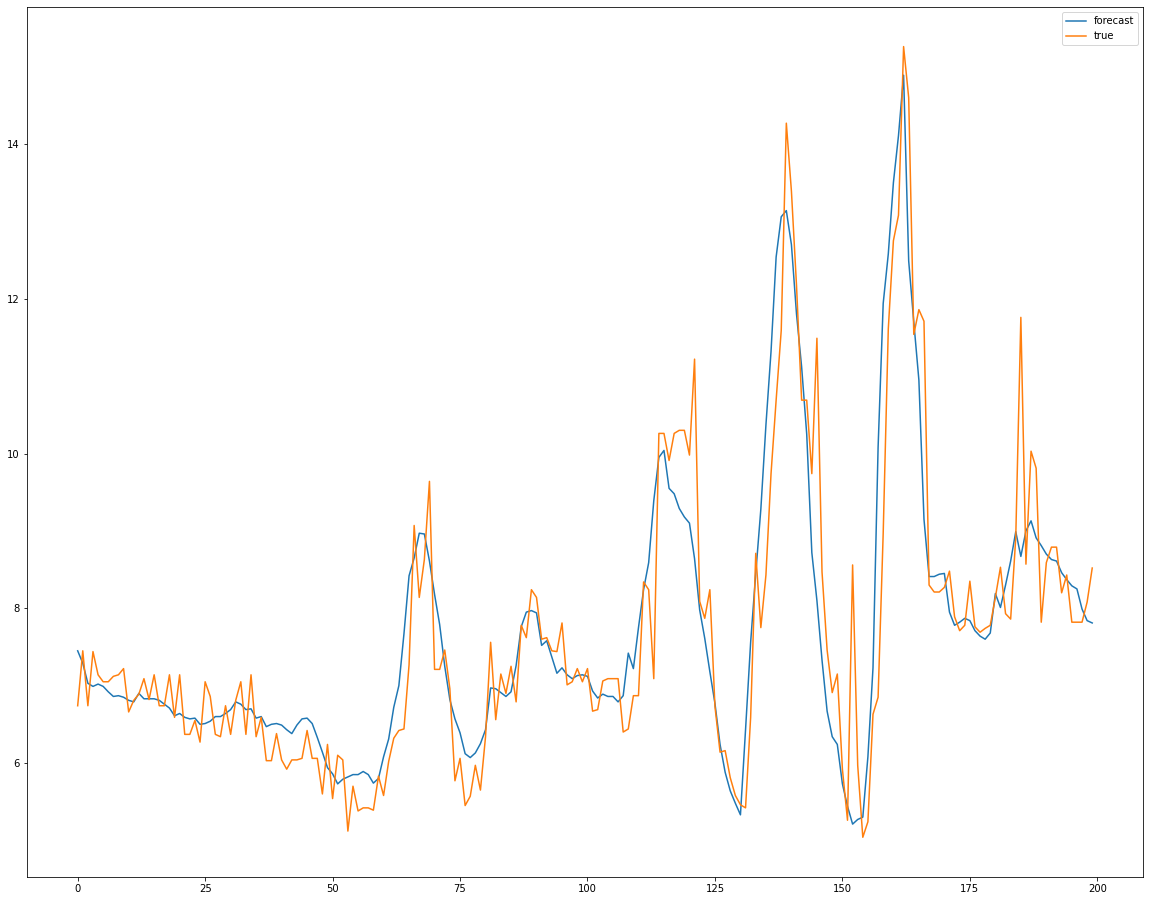

MSE: 3.086891638127854
RMSE: 1.7569552180200423
MAE: 1.1690582191780825
Analyzing predictions for VPact (mbar)


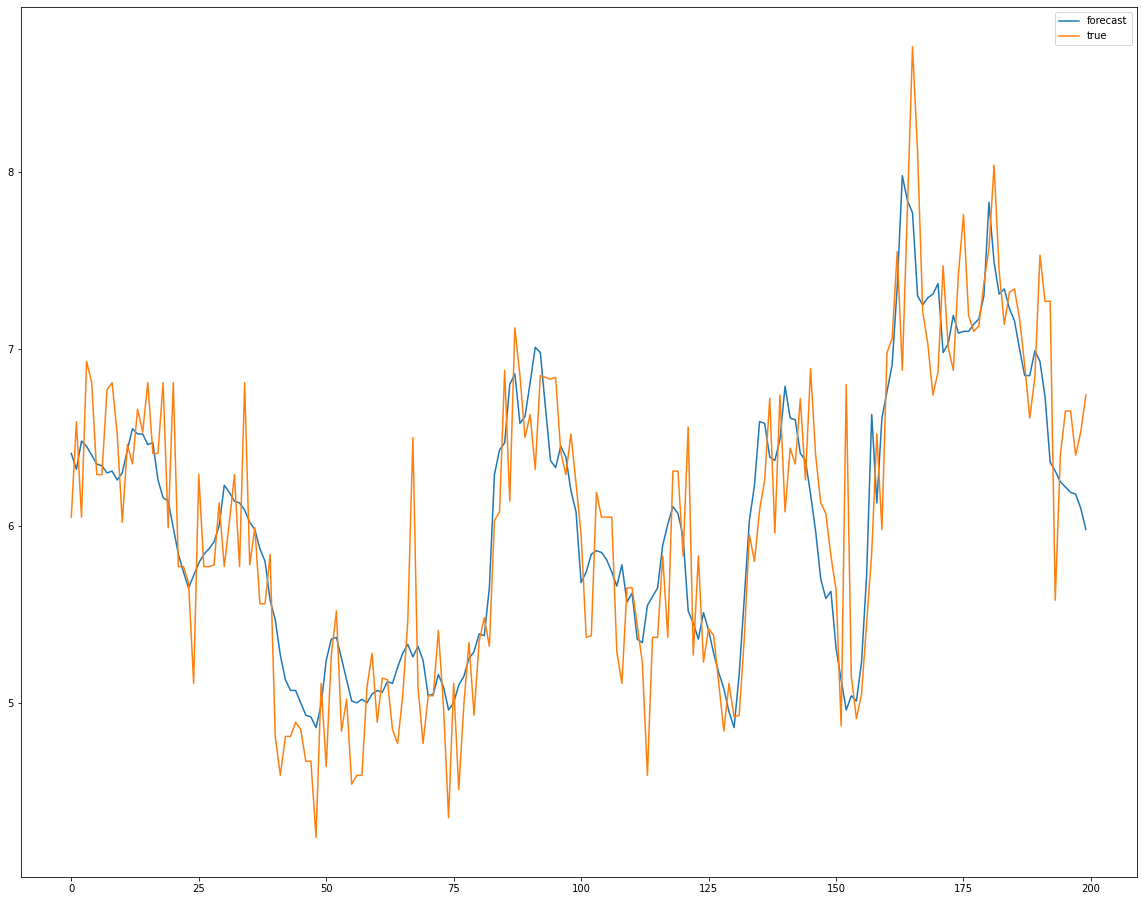

MSE: 0.601227725456621
RMSE: 0.7753887576284691
MAE: 0.5522959474885845
Analyzing predictions for VPdef (mbar)


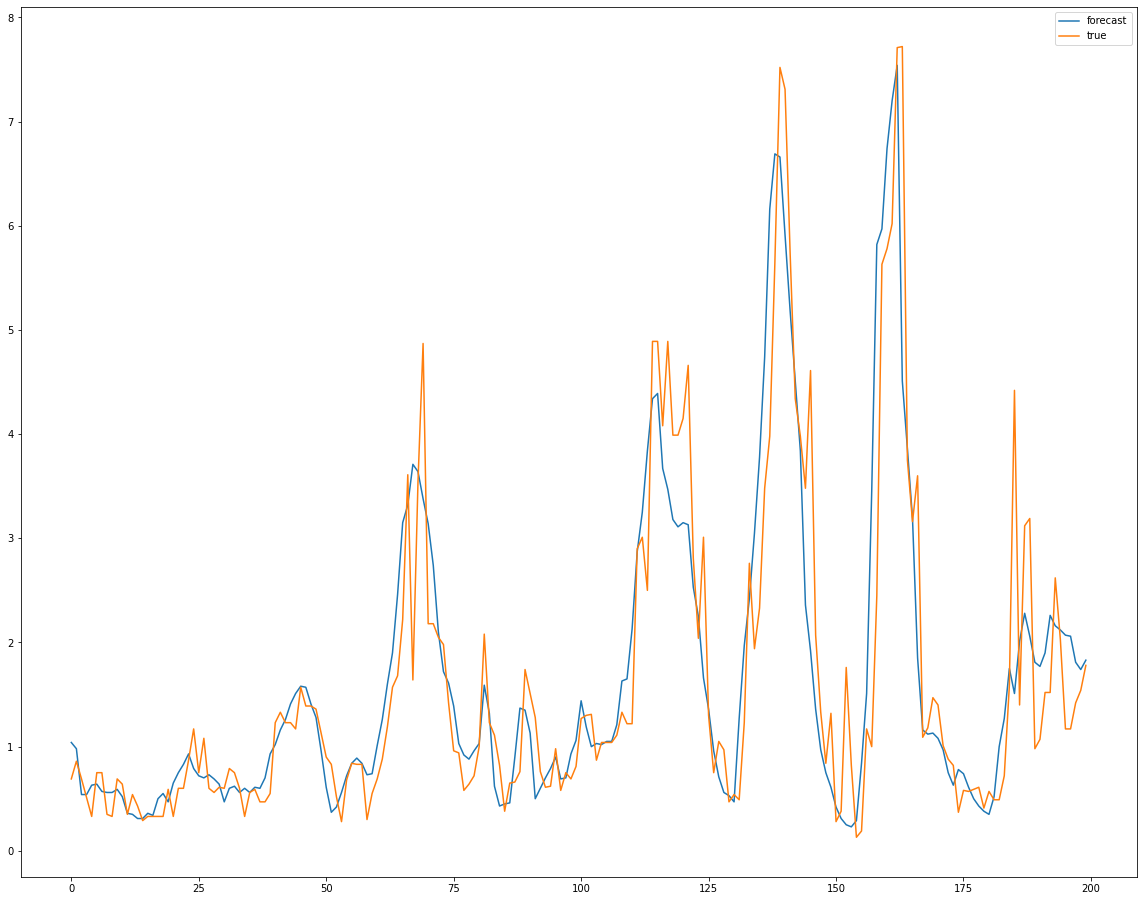

MSE: 3.077963184931507
RMSE: 1.7544124899611
MAE: 1.0952539954337899
Analyzing predictions for sh (g/kg)


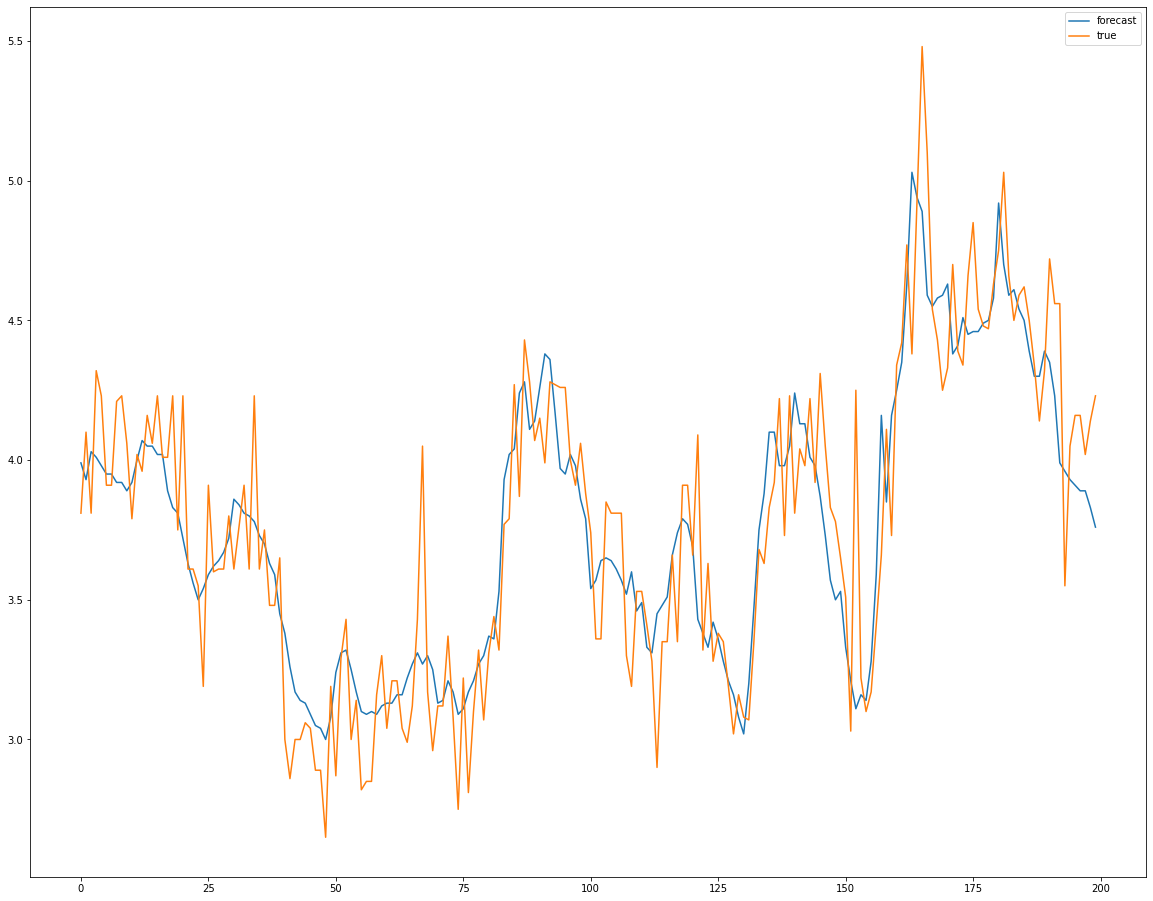

MSE: 0.23646616723744296
RMSE: 0.4862778703965902
MAE: 0.344359303652968
Analyzing predictions for H2OC (mmol/mol)


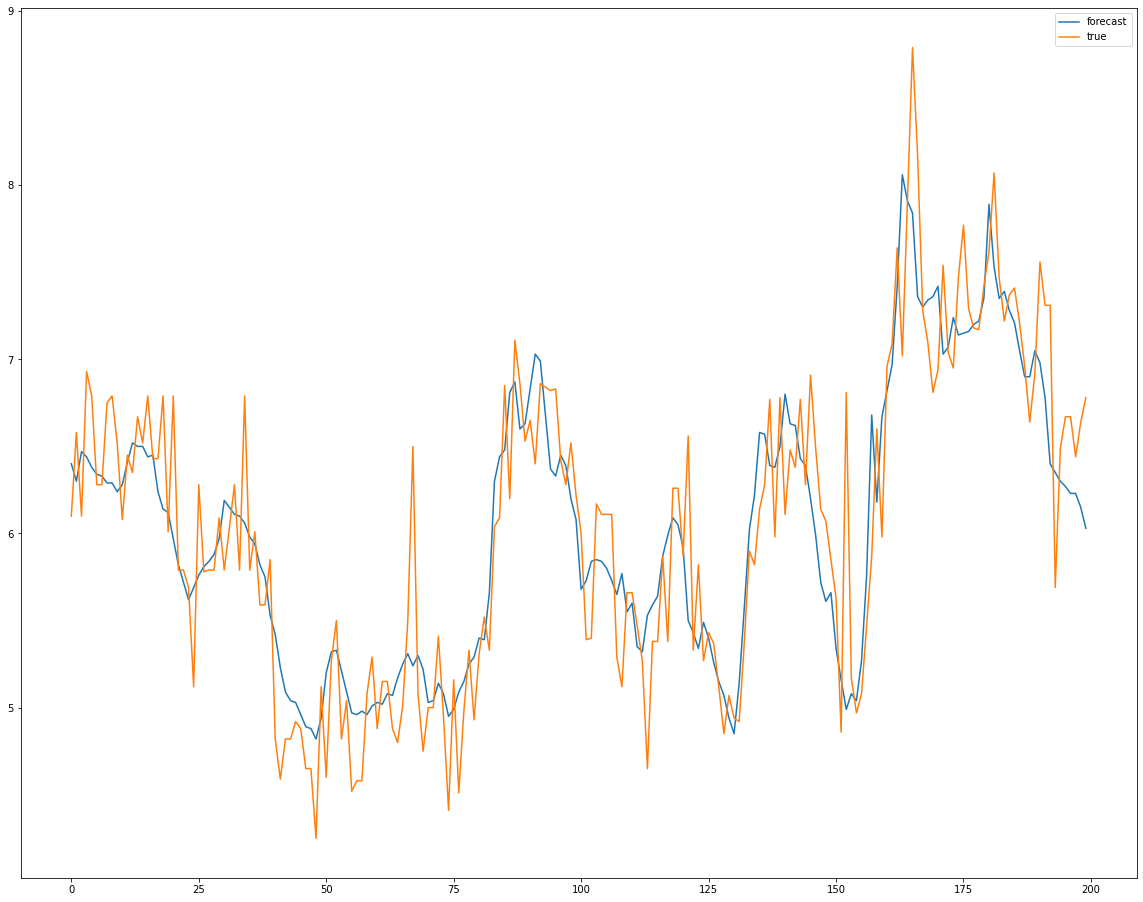

MSE: 0.5987423087899544
RMSE: 0.7737844071768016
MAE: 0.548585901826484
Analyzing predictions for rho (g/m**3)


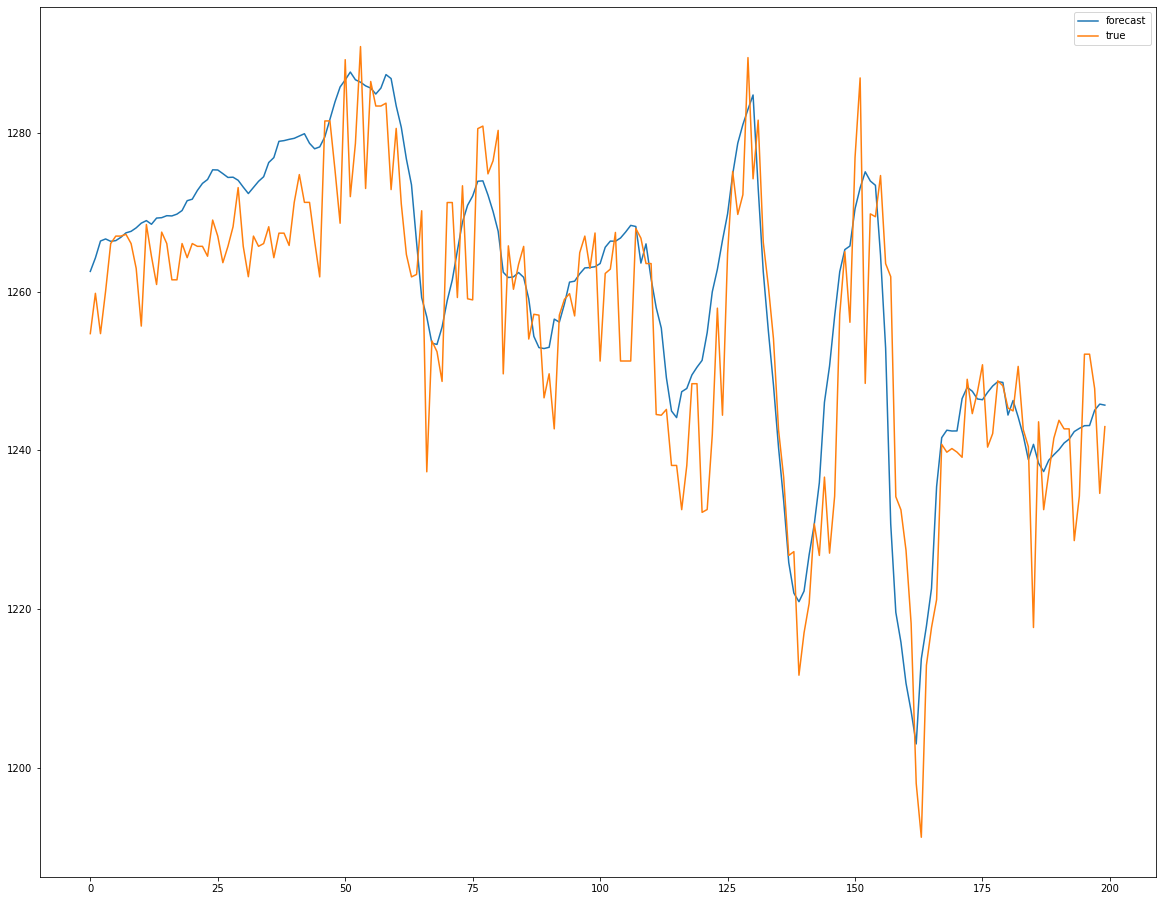

MSE: 67.72239384988585
RMSE: 8.229361691521758
MAE: 6.408417522831049
Analyzing predictions for wv (m/s)


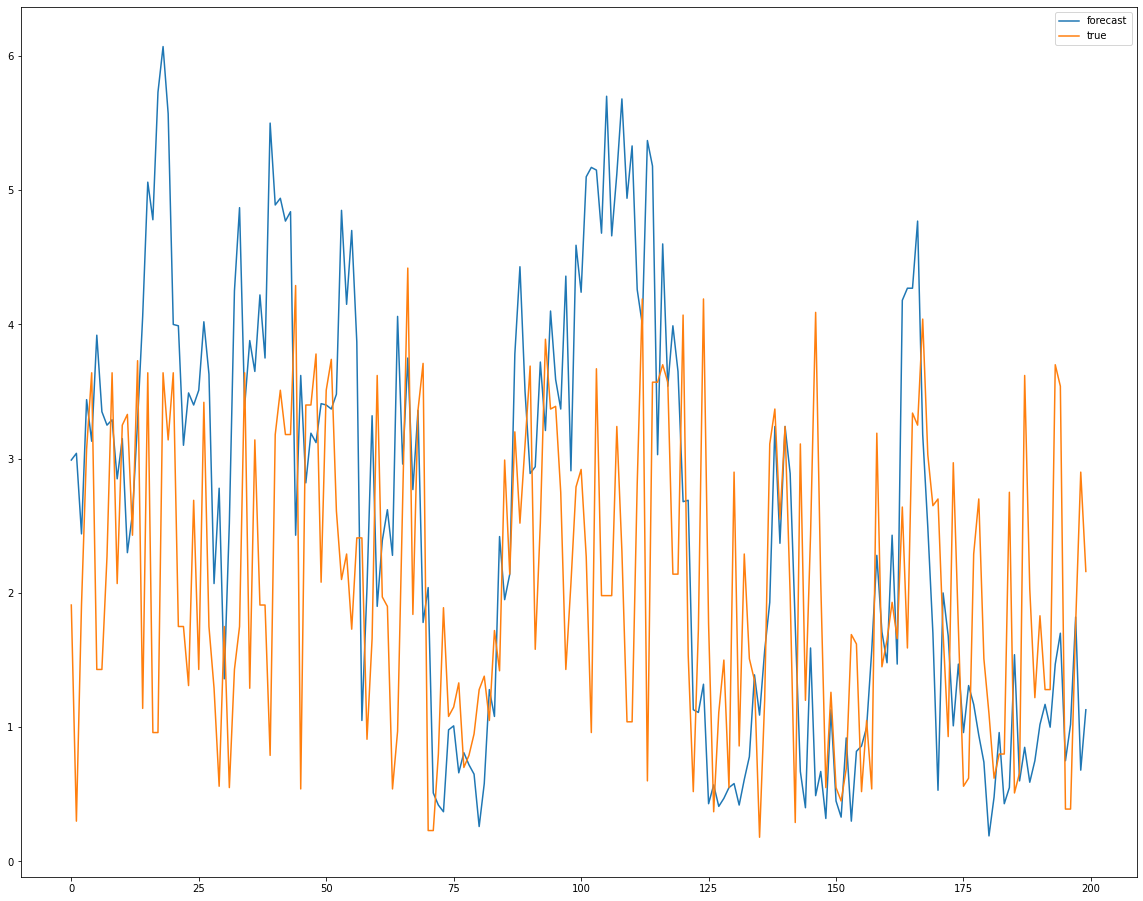

MSE: 1.7296071917808216
RMSE: 1.3151453120400123
MAE: 0.977648401826484
Analyzing predictions for max. wv (m/s)


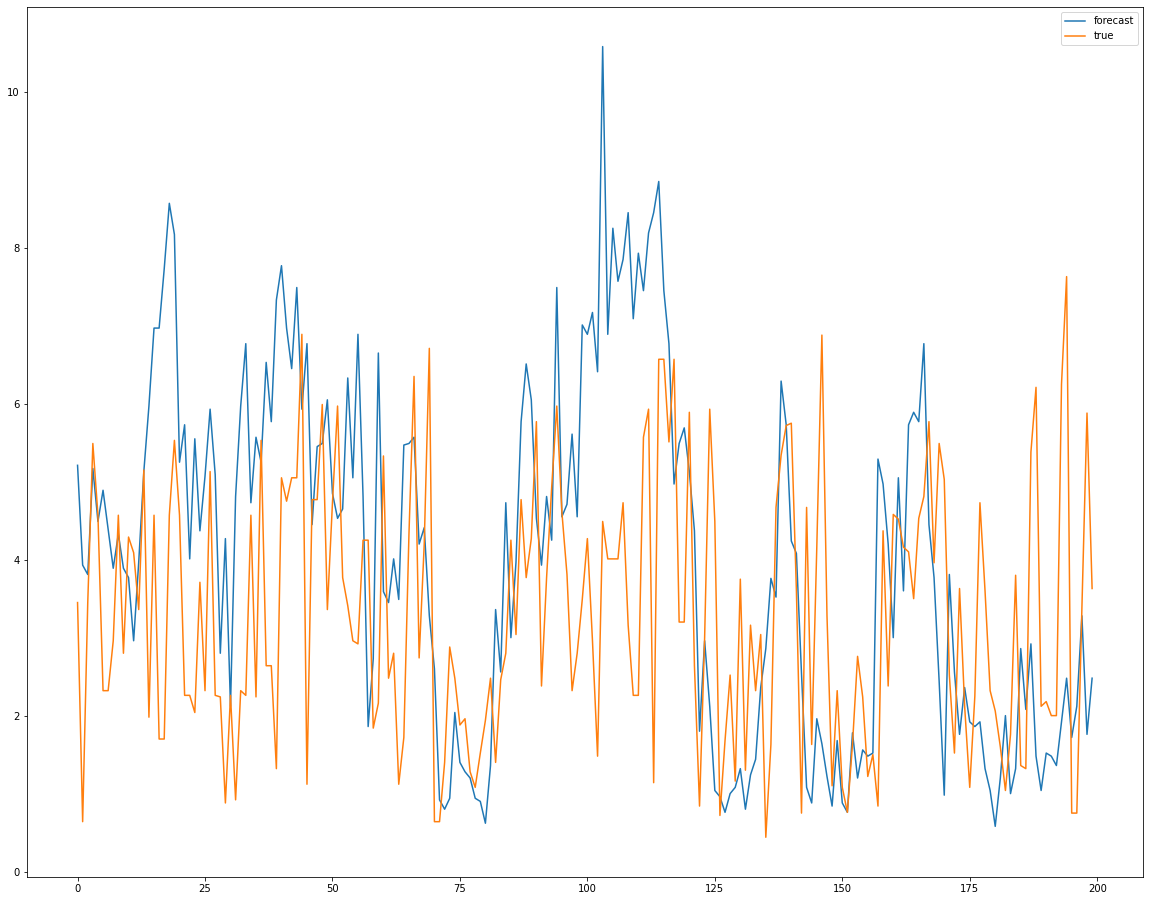

MSE: 4.1187066352739725
RMSE: 2.029459690477732
MAE: 1.516853595890411
Analyzing predictions for wd (deg)


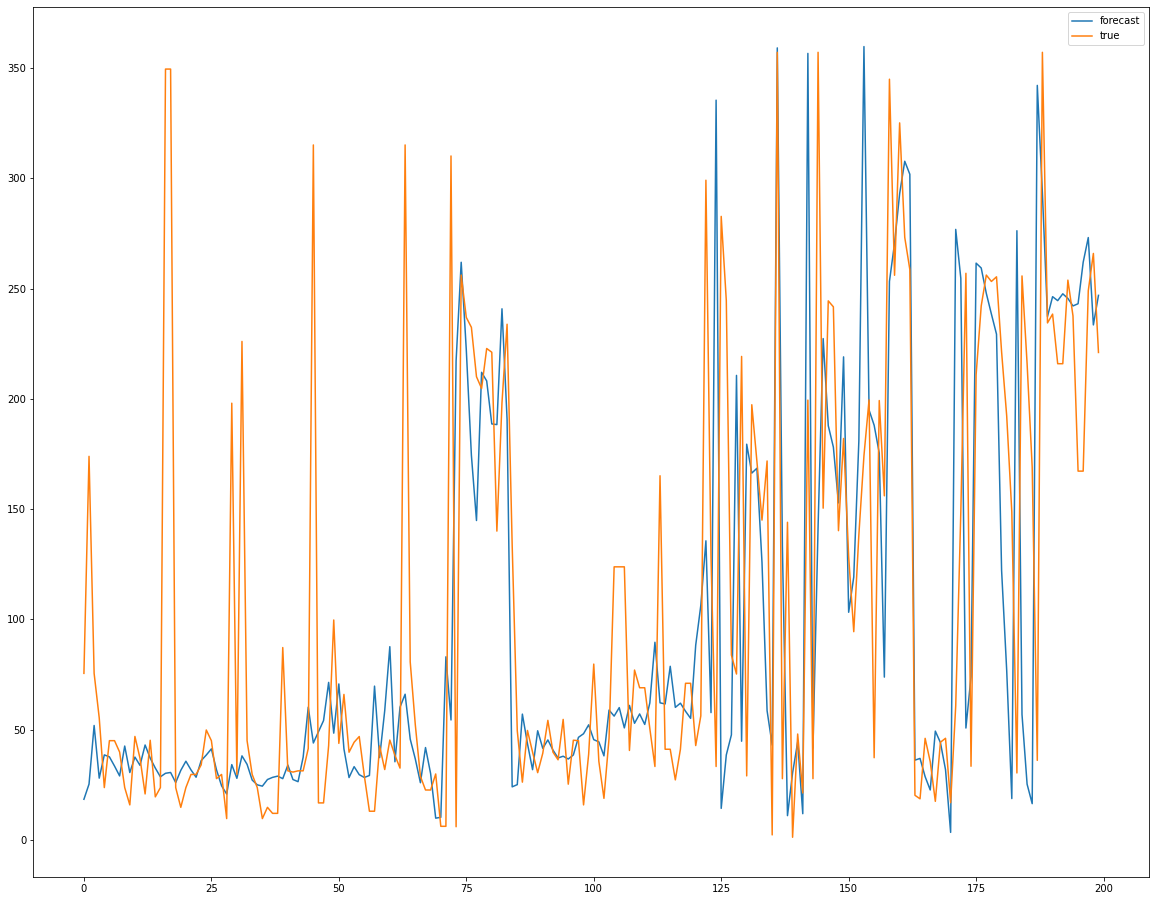

MSE: 9399.272637557078
RMSE: 96.94984599037318
MAE: 62.48525970319634


In [23]:
for feature in original_data_for_insert.columns[1:]:
    print(f'Analyzing predictions for {feature}')
    true_values, predicted_values = get_predictions(feature)
    plot_results(true_values, predicted_values)
    print_results(true_values, predicted_values)

### Summary

From the plots above we can see that the method is able to predict pretty accurately for feature like VPdef, VPmax, rh(%) etc. predict roughly accurately for features like H20C, rho and is not that great for features like wd, max.vv, wv. Given how simple the approach is and doesn't involve any feature engineering, it does pretty good in some spots! 

We can improve these predictions by using more complex methods like LSTMs which are better suited to handle data like these.

### Delete the Index

Once we don't have use of the index we can delete them.


*Note: Index deletion is permanent*

In [24]:
for name in pinecone.list_indexes():
    pinecone.delete_index(name)